<a href="https://colab.research.google.com/github/ykato27/Image-Classification/blob/main/Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cifar10のデータ・セットを取得

In [1]:
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

dataset_size = trainset.data.shape[0]
dataset_size


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


50000

- ラベルごとにデータを分けて保存するための処理を記述
- 同一ラベルと異なるラベルで学習するための準備

In [2]:
from collections import defaultdict


train_data_set = defaultdict(list)

for index, label in enumerate(trainset.targets):
    train_data_set[label].append(Image.fromarray(trainset.data[index]))

test_data_set = defaultdict(list)

for index, label in enumerate(testset.targets):
    test_data_set[label].append(Image.fromarray(testset.data[index]))

- Cifar10の学習データ取得するためのクラス
- indexが奇数の場合は同一ラベルのデータ
- 偶数の場合は異なるラベルのデータを取得

In [3]:
import os
import random
import time

import numpy as np
from numpy.random import choice as npc
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as dset


class Cifar10Train(Dataset):
    def __init__(self, datas, transform=None):
        super(Cifar10Train, self).__init__()
        np.random.seed(0)
        self.datas = datas
        self.num_classes = len(datas)
        self.transform = transform

    def __len__(self):
        size = len(self.datas) * len(self.datas[0])
        return size

    def __getitem__(self, index):
        # image1 = random.choice(self.dataset.imgs)
        label = None
        img1 = None
        img2 = None
        # get image from same class
        if index % 2 == 1:
            label = 1.0
            idx1 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx1])
        # get image from different class
        else:
            label = 0.0
            idx1 = random.randint(0, self.num_classes - 1)
            idx2 = random.randint(0, self.num_classes - 1)
            while idx1 == idx2:
                idx2 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx2])

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return (
            image1,
            image2,
            torch.from_numpy(np.array([label], dtype=np.float32)),
        )

Cifar10の評価データ取得するためのクラス

In [4]:
class Cifar10Test(Dataset):
    def __init__(self, datas, transform=None, times=200, way=20):
        np.random.seed(1)
        super(Cifar10Test, self).__init__()
        self.transform = transform
        self.times = times
        self.way = way
        self.img1 = None
        self.c1 = None
        self.datas = datas
        self.num_classes = len(datas)

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        # generate image pair from same class
        if idx == 0:
            self.c1 = random.randint(0, self.num_classes - 1)
            self.img1 = random.choice(self.datas[self.c1])
            img2 = random.choice(self.datas[self.c1])
        # generate image pair from different class
        else:
            c2 = random.randint(0, self.num_classes - 1)
            while self.c1 == c2:
                c2 = random.randint(0, self.num_classes - 1)
            img2 = random.choice(self.datas[c2])

        if self.transform:
            img1 = self.transform(self.img1)
            img2 = self.transform(img2)
        return img1, img2

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 1),
            nn.ReLU(),
        )
        self.liner = nn.Sequential(nn.Linear(256, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        return out

In [6]:
data_transforms = transforms.Compose(
    [transforms.RandomAffine(15), transforms.ToTensor()]
)


trainSet = Cifar10Train(train_data_set, transform=data_transforms)

trainLoader = DataLoader(
    trainSet, batch_size=128, shuffle=False, num_workers=4
)

testSet = Cifar10Test(
    test_data_set, transform=transforms.ToTensor(), times=200, way=5
)
testLoader = DataLoader(testSet, batch_size=5, shuffle=False, num_workers=4)

loss_fn = torch.nn.BCEWithLogitsLoss(size_average=True)
net = Siamese()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


SIAMESE NETWORKをGPUで学習するための変換設定

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    net.cuda()

net.train()

optimizer = torch.optim.Adam(net.parameters(), lr=0.00006)
optimizer.zero_grad()

SIAMESE NETWORKを学習

In [8]:
from collections import deque
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable


train_loss = []
loss_val = 0
time_start = time.time()
queue = deque(maxlen=20)
max_iter = 50000

for batch_id, (img1, img2, label) in enumerate(trainLoader, 1):
    if batch_id > max_iter:
        break
    if device == "cuda":
        img1, img2, label = (
            Variable(img1.cuda()),
            Variable(img2.cuda()),
            Variable(label.cuda()),
        )
    else:
        img1, img2, label = Variable(img1), Variable(img2), Variable(label)
    optimizer.zero_grad()
    output = net.forward(img1, img2)
    loss = loss_fn(output, label)
    loss_val += loss.item()
    loss.backward()
    optimizer.step()
    if batch_id % 10 == 0:
        print(
            "[%d]\tloss:\t%.5f\ttime lapsed:\t%.2f s"
            % (batch_id, loss_val / 10, time.time() - time_start)
        )
        loss_val = 0
        time_start = time.time()
    if batch_id % 100 == 0:
        torch.save(
            net.state_dict(), "./model-inter-" + str(batch_id + 1) + ".pt"
        )
    if batch_id % 100 == 0:
        right, error = 0, 0
        for _, (test1, test2) in enumerate(testLoader, 1):
            if device == "cuda":
                test1, test2 = test1.cuda(), test2.cuda()
            test1, test2 = Variable(test1), Variable(test2)
            output = net.forward(test1, test2).data.cpu().numpy()
            pred = np.argmax(output)
            if pred == 0:
                right += 1
            else:
                error += 1
        print("*" * 70)
        print(
            "[%d]\tTest set\tcorrect:\t%d\terror:\t%d\tprecision:\t%f"
            % (batch_id, right, error, right * 1.0 / (right + error))
        )
        print("*" * 70)
        queue.append(right * 1.0 / (right + error))
    train_loss.append(loss_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[10]	loss:	0.69309	time lapsed:	7.15 s
[20]	loss:	0.69296	time lapsed:	6.72 s
[30]	loss:	0.69258	time lapsed:	6.57 s
[40]	loss:	0.69166	time lapsed:	6.48 s
[50]	loss:	0.68987	time lapsed:	6.56 s
[60]	loss:	0.68705	time lapsed:	6.56 s
[70]	loss:	0.68750	time lapsed:	6.41 s
[80]	loss:	0.68637	time lapsed:	6.51 s
[90]	loss:	0.68212	time lapsed:	6.54 s
[100]	loss:	0.68371	time lapsed:	6.46 s
**********************************************************************
[100]	Test set	correct:	60	error:	140	precision:	0.300000
**********************************************************************
[110]	loss:	0.68607	time lapsed:	9.12 s
[120]	loss:	0.68416	time lapsed:	6.43 s
[130]	loss:	0.67877	time lapsed:	6.46 s
[140]	loss:	0.67811	time lapsed:	6.51 s
[150]	loss:	0.68157	time lapsed:	6.49 s
[160]	loss:	0.67742	time lapsed:	6.46 s
[170]	loss:	0.68004	time lapsed:	6.51 s
[180]	loss:	0.67540	time lapsed:	6.41 s
[190]	loss:	0.67807	time lapsed:	6.49 s
[200]	loss:	0.66870	time lapsed:	6.50 s
*********

検索処理のためのデータ・セットクラスを作成

In [9]:
class SerachDataSet(Dataset):
    def __init__(self, datas, transform=None):
        super(SerachDataSet, self).__init__()
        np.random.seed(0)
        self.datas = datas
        self.num_classes = len(datas)
        self.transform = transform

    def __len__(self):
        size = len(self.datas) * len(self.datas[0])
        return size

    def __getitem__(self, index):
        # image1 = random.choice(self.dataset.imgs)
        label = None
        img1 = None
        idx1 = random.randint(0, self.num_classes - 1)
        image1 = random.choice(self.datas[idx1])

        if self.transform:
            image1 = self.transform(image1)
        return image1, idx1


testSet = SerachDataSet(test_data_set, transform=transforms.ToTensor())
testLoader = DataLoader(testSet, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


学習したSIAMESE NETWORKで評価データのすべての画像特徴量を取得

In [10]:
import numpy as np
import torch.nn as nn


net = net.eval()


# - test images -
test_output = []
test_output_name = []
test_image = []

for batch_idx, (x, label) in enumerate(testLoader):
    feature = net.forward_one(x)
    test_image.append(x)
    test_output.append(np.array(feature.cpu().tolist()))
    test_output_name.append(label)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


効率よく検索できるライブラリ`nmslib`を導入

In [11]:
! pip install nmslib

     |████████████████████████████████| 13.5MB 230kB/s 
     |████████████████████████████████| 194kB 53.2MB/s 


In [12]:
import nmslib


index = nmslib.init(method="hnsw", space="cosinesimil")
index.addDataPointBatch(test_output)
index.createIndex({"post": 2}, print_progress=True)

検索対象とする画像を表示

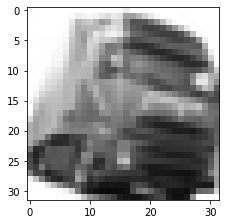

In [13]:
import matplotlib.pyplot as plt


def show_images(images, figsize=(20, 10), columns=5):
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        image = image.transpose(0, 1).transpose(1, 2)
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)


show_images(test_image[0])

検索対象の画像をクエリとして画像の検索処理をしてTop19のデータを取得

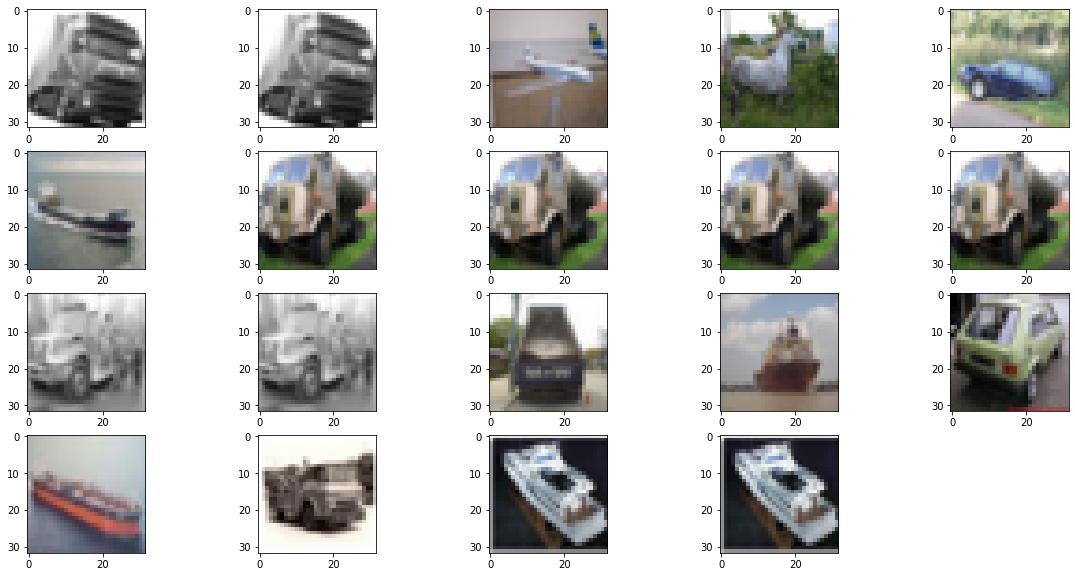

In [14]:
ids, distances = index.knnQuery(test_output[0], k=19)
search_images = []
for id, distance in zip(ids, distances):
    search_images.append(test_image[id][0])

show_images(search_images)